This Notebook follow this [blog](https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b)

[NetworkX](https://networkx.org/documentation/networkx-2.3/index.html)

- Let’s start by building a simple undirected graph (G) using NetworkX. The graph G will consist of 6 nodes and the feature of each node will correspond to that particular node number. For example, node 1 will have a node feature of 1, node 2 will have a node feature of 2, and so on. 

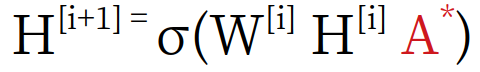


Graph Info:
 Graph named 'G' with 6 nodes and 7 edges

 Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


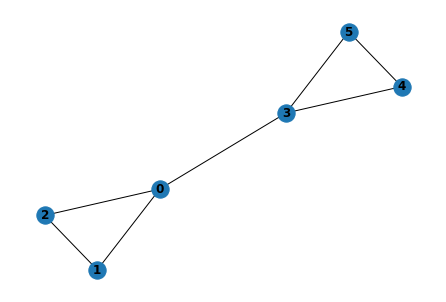

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import  fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category= UserWarning)


#Initialize the graph
G = nx.Graph(name = "G")

#Create Nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(6):
  G.add_node(i, name = i)

# Define the edges and the edges to graph
edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

# See graph info
print('\nGraph Info:\n', nx.info(G))

# Insppect the node features
print('\n Graph Nodes: ',G.nodes.data())

#Plot the graph
nx.draw(G, with_labels = True, font_weight = 'bold')
plt.show()


- The next step is to obtain the Adjacency Matrix (A) and Node Features Matrix (X) from graph G.

In [2]:
# Get it as a numpy array
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis =1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


- Now, let’s investigate how by inserting A into the forward pass equation adds to richer feature representation of the model. We are going to perform dot product of A and X. Let’s call the result of this dot product operation as AX in this article.

In [3]:
# Dot Product of A and X
AX = np.dot(A,X)
print("dot Product of A and X (AX):\n", AX)

dot Product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


- To address this problem, we now add self-loops to each node of A. Adding self-loops is basically a mechanism to connect a node to itself. That being said, all the diagonal elements of Adjacency Matrix A will now become 1 because each node is connected to itself. Let’s call A with self-loops added as A_hat and recalculate AX, which is now the dot product of A_hat and X

In [5]:
# Add Self Loops
G_self_loops = G.copy()

self_loops = []

for i in range(G.number_of_nodes()):
  self_loops.append((i, i))

G_self_loops.add_edges_from(self_loops)

# Let's check all the edges of G_self_loops affter adding the self loops
print("Edges of G with Self-loops:\n", G_self_loops.edges)

# Get the adjacency Matrix(A) and Node Feature Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr= 'name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

#Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with Self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


- Now, you might recognize another problem. The elements of AX are not normalized. Similar to data pre-processing for any Neural Networks operation, we need to normalize the features to prevent numerical instabilities and vanishing/exploding gradients in order for the model to converge. In GCNs, we normalize our data by calculating the Degree Matrix (D) and performing dot product operation of the inverse of D with AX

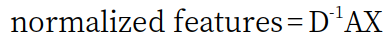

- the term “degree” refers to the number of edges a node is connected to.

In [9]:
# Get the Degree Martix of the added self-loops graph
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

# Convert the Degree Matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

# Find the Inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print("Inverse of D:\n", D_inv)

# Dot product of D and AX for normalization
DAX = np.dot(D_inv, AX)
print("DAX:\n", DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


- Let’s take a look back at our graph. Node 3 has 3 incident edges, while nodes 4 and 5 only have 2 incident edges. The fact that node 3 has a higher degree than node 4 and 5 leads to a lower weighting of node 3’s features in DAX. In other words, the lower the degree of a node, the stronger that a node belongs to a certain group or cluster.

##### symmetric normalization

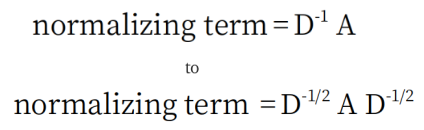

In [10]:
# Calculate the Normalized values using new symmetric normalization equation
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX) 

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


- We are going to build a 2-layer GCN using ReLu as the activation function.  In this experiment, we are going to set 4 neurons for the hidden layer. As we will be plotting the feature representations in 2 dimensions, there will be 2 output neurons.

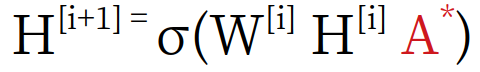

In [14]:
# Initial the weights
np.random.seed(77777)
n_h = 4 # Number of Neurons in the hidden layer
n_y = 2 # Number of Output layer

W0 = np.random.randn(X.shape[1], n_h) *0.01
W1 = np.random.randn(n_h, n_y) *0.01

# Use Relu
def relu(x):
  return np.maximum(0,x)

#Build GCN layer
def gcn(A, H, W):
  I = np.identity(A.shape[0]) #create Identity Matrix of A
  A_hat = A + I # add a self Loop
  D = np.diag(np.sum(A_hat, axis = 0)) # Create Degree Matrix of A
  D_half_norm = fractional_matrix_power(D,  -0.5) # Calcuate d to the power of -0.5
  eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
  return relu(eq)

# Do forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A, H1,W1)
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00027758 0.        ]
 [0.00017298 0.        ]
 [0.00017298 0.        ]
 [0.00053017 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]]


##### Key Takeways 
- The term ‘convolution’ in Graph Convolutional Networks is similar to Convolutional Neural Networks in terms of weight sharing